In [82]:
import cv2
import numpy as np

import numpy.typing as npt
from xml.etree import ElementTree
from matplotlib.path import Path
import torch

In [83]:
from utils import mask_frame, parse_outputs, regionize_image

In [84]:

%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

In [85]:
PATCH_SIZE = 60

SAMPLE_SIZE = 512

In [86]:
def get_patch(frame, x, y):
    return frame[y:y+PATCH_SIZE, x:x+PATCH_SIZE]

In [87]:
def get_all_patches(frame):
    height, width, _ = frame.shape
    assert height % PATCH_SIZE == 0
    assert width % PATCH_SIZE == 0
    patches = np.ndarray((height // PATCH_SIZE, width // PATCH_SIZE, PATCH_SIZE, PATCH_SIZE, 3), dtype=np.uint32)
    for y in range(0, height, PATCH_SIZE):
        for x in range(0, width, PATCH_SIZE):
            patches[y // PATCH_SIZE, x // PATCH_SIZE] = get_patch(frame, x, y)
    return patches

In [88]:
tree = ElementTree.parse('./jnc00.mp4.mask.xml')
mask = tree.getroot()

In [89]:
def get_bitmap(frame: npt.NDArray, mask: ElementTree.Element):
    domain = mask.find('.//polygon[@label="domain"]')
    assert domain is not None

    domain = domain.attrib['points']
    domain = domain.replace(';', ',')
    domain = np.array([
        float(pt) for pt in domain.split(',')]).reshape((-1, 2))
    tl = (int(np.min(domain[:, 1])), int(np.min(domain[:, 0])))
    br = (int(np.max(domain[:, 1])), int(np.max(domain[:, 0])))
    domain_poly = Path(domain)
    width, height = int(frame.shape[1]), int(frame.shape[0])
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    x, y = x.flatten(), y.flatten()
    pixel_points = np.vstack((x, y)).T
    bitmap = domain_poly.contains_points(pixel_points)
    bitmap = bitmap.reshape((height, width, 1))

    return bitmap

In [90]:
cap = cv2.VideoCapture('./jnc00.mp4')

num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

all_patches = []
idx = 0
bitmap = None
with torch.no_grad():
    while idx < num_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        if bitmap is None:
            bitmap = get_bitmap(frame, mask)
            bitmap = bitmap.astype(np.uint8)
            bitmap = torch.from_numpy(bitmap).to('cuda:0')
        frame_masked = torch.from_numpy(frame).to('cuda:0')
        frame = bitmap * frame_masked
        frame = frame.cpu().numpy()

        # print(idx)
        all_patches.append(get_all_patches(frame))

        idx += SAMPLE_SIZE

In [91]:
mean: npt.NDArray = sum(all_patches) / len(all_patches)

In [92]:
height, width, _, _, _ = mean.shape

In [93]:
patches = np.ndarray((height, width, PATCH_SIZE, PATCH_SIZE, 3), dtype=np.uint32)

for y in range(height):
    for x in range(width):
        m = mean[y, x]
        m_dist = np.inf
        m_patch = None
        for p in range(len(all_patches)):
            # sum all elements in ndarray
            dist = np.sum(np.abs(all_patches[p][y, x] - m))
            if dist < m_dist:
                m_dist = dist
                m_patch = all_patches[p][y, x]
        patches[y, x] = m_patch

In [94]:
def reconstruct_image(patches):
    height, width, _, _, _ = patches.shape
    frame = np.ndarray((height * PATCH_SIZE, width * PATCH_SIZE, 3), dtype=np.uint8)
    for y in range(height):
        for x in range(width):
            frame[y*PATCH_SIZE:(y+1)*PATCH_SIZE, x*PATCH_SIZE:(x+1)*PATCH_SIZE] = patches[y, x]
    return frame

In [95]:
frame = reconstruct_image(patches)

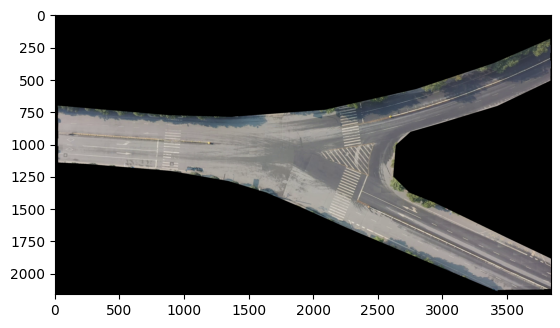

In [96]:
plt.imshow(frame[:, :, ::-1])
plt.show()

In [97]:
cv2.imwrite('test.jpg', frame)

True

In [98]:
ref_frame = frame
ref_frame = torch.from_numpy(ref_frame).to('cuda:0')

In [109]:
ref_frame2 = ref_frame

In [120]:
THRESHOLD = 40

In [121]:
cap = cv2.VideoCapture('./jnc00.mp4')
writer = cv2.VideoWriter('output2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (frame.shape[1], frame.shape[0] * 2))

num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

all_patches = []
idx = 0
img = torch.empty((frame.shape[0] * 2, frame.shape[1], 3), dtype=torch.uint8)
with torch.no_grad():
    while idx < 200:
        print(idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame_masked = torch.from_numpy(frame).to('cuda:0')
        frame = bitmap * frame_masked
        # frame = frame.cpu().numpy()

        if idx > 0:
            # img = np.ndarray((frame.shape[0] * 2, frame.shape[1], 3), dtype=np.uint8)
            dif = torch.abs(frame - ref_frame2)
            # dif = torch.pow(dif, 2).sum(dim=2).sqrt()
            dif = dif > THRESHOLD
            dif = dif.to(torch.uint8)
            # dif = torch.abs(frame - ref_frame2)
            # dif = dif > THRESHOLD
            # dif = dif.to(np.uint8)

            img[:frame.shape[0]] = frame
            img[frame.shape[0]:] = (dif * 255)

            writer.write(img.cpu().numpy())


        idx += 1

writer.release()
cap.release()
cv2.destroyAllWindows()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [ ]:
THRESHOLD = 20

In [ ]:
cap = cv2.VideoCapture('./jnc00.mp4')
writer = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (frame.shape[1], frame.shape[0] * 2))

num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

all_patches = []
idx = 0
img = torch.empty((frame.shape[0] * 2, frame.shape[1], 3), dtype=torch.uint8)
with torch.no_grad():
    while idx < 200:
        print(idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame_masked = torch.from_numpy(frame).to('cuda:0')
        frame = bitmap * frame_masked
        # frame = frame.cpu().numpy()

        if idx > 0:
            # img = np.ndarray((frame.shape[0] * 2, frame.shape[1], 3), dtype=np.uint8)
            dif = torch.abs(frame - ref_frame)
            dif = torch.pow(dif, 2).sum(dim=2).sqrt()
            dif = dif > THRESHOLD
            dif = dif.to(torch.uint8)
            # dif = np.abs(frame - ref_frame)
            # dif = dif > THRESHOLD
            # dif = dif.astype(np.uint8)

            img[:frame.shape[0]] = frame
            img[frame.shape[0]:] = (dif * 255)[:, :, torch.newaxis]

            writer.write(img.cpu().numpy())

        ref_frame = frame

        idx += 1

writer.release()
cap.release()
cv2.destroyAllWindows()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
